### Throw / Gravity predictor

A small test project for RNNs in Keras. Simulates a thrown ball with a parabola curve and bounces from the ground and tries to predict it.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import os
import matplotlib.pyplot as plt
import math
from livelossplot import PlotLossesKeras

/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

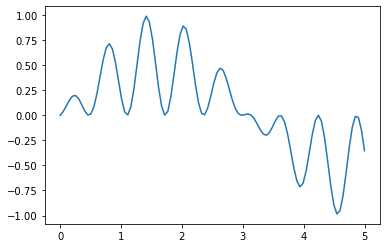

In [2]:
def our_function(x):
    #return math.sin(x)
    return math.sin(x) * (math.sin(10*x) / 2 + 0.5)

def generate_series(start_x, end_x, resolution):
    xs = np.linspace(start_x, end_x, resolution)
    ys = [our_function(x) for x in xs]
    return np.array(list(zip(xs, ys)))

throw = generate_series(0, 5, 100)
plt.plot(throw[:, 0], throw[:, 1])

(5, 40, 2) (5, 2)


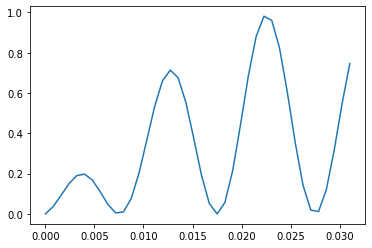

In [3]:
# Generates a specified amount of data
def generate_data(start_x, series_length, n_series, step_size=0.1):
    total_curve_length = series_length + n_series + 1
    end_x = start_x + step_size * total_curve_length
    resolution = (end_x - start_x) / step_size + 1
    og_series = generate_series(start_x, end_x, resolution)
    
    Xy = np.ndarray(shape=(n_series, series_length + 1, 2))
    X = np.ndarray(shape=(n_series, series_length, 2))
    y = np.ndarray(shape=(n_series, 2))
    
    i = 0
    for k in range(n_series):
        Xy[i, :, :] = og_series[i:(i+series_length+1), :]
        Xy[i, :, 0] = np.mod(Xy[i, :, 0], 20*math.pi) / (20*math.pi)
        i += 1
        
    X = Xy[:, :-1, :]
    y = Xy[:, -1, :]
    
    return X, y

X, y = generate_data(0, 40, 5, step_size=0.05)
print(X.shape, y.shape)
plt.plot(X[0, :, 0], X[0, :, 1])

In [4]:
SERIES_LENGTH = 40

X_all, y_all = generate_data(0, SERIES_LENGTH, 3000)
X_all = X_all[:, :, :]
y_all = y_all[:, 1:]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_all, y_all, test_size=0.1, shuffle=True)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2700, 40, 2) (2700, 1) (300, 40, 2) (300, 1)


### Create simple model

In [5]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.4, return_sequences=True))
model.add(keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.4))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(64, activation='tanh'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(1, activation='tanh'))

model.build((None, SERIES_LENGTH, 2))

model.compile(
    optimizer='adam',
    loss='mae')

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 32)            4480      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         


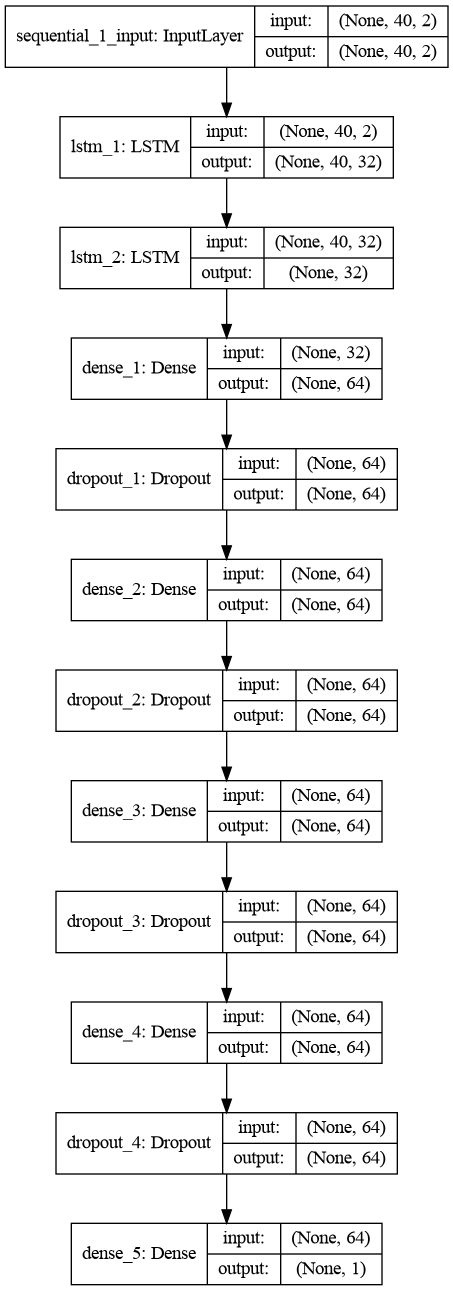

In [6]:
from IPython.display import Image
import pydot

keras.utils.plot_model(model, to_file=f'modelplot.png', show_shapes=True)

Image(f'modelplot.png')

In [7]:
y_train.shape

(2700, 1)

In [8]:
hist = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=250,
    batch_size=256,
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2700 samples, validate on 300 samples
Epoch 1/250
2700/2700 [==============================] - 4s 2ms/step - loss: 0.3165 - val_loss: 0.3169
Epoch 2/250
2700/2700 [==============================] - 2s 690us/step - loss: 0.3001 - val_loss: 0.2865
Epoch 3/250
2700/2700 [==============================] - 2s 686us/step - loss: 0.2883 - val_loss: 0.2625
Epoch 4/250
2700/2700 [==============================] - 2s 640us/step - loss: 0.2785 - val_loss: 0.2483
Epoch 5/250
2700/2700 [==============================] - 2s 662us/step - loss: 0.2752 - val_loss: 0.2457
Epoch 6/250
2700/2700 [==============================] - 2s 699us/step - loss: 0.2716 - val_loss: 0.2528
Epoch 7/250
2700/2700 [==============================] - 2s 666us/step - loss: 0.2732 - val_loss: 0.2468
Epoch 8/250
2700/2700 [==============================] - 2s 680us/step - loss: 0.2701 - val_loss: 0.2456
Epoch 9/250
2700/270

Epoch 73/250
2700/2700 [==============================] - 2s 658us/step - loss: 0.2261 - val_loss: 0.2145
Epoch 74/250
2700/2700 [==============================] - 2s 643us/step - loss: 0.2254 - val_loss: 0.2178
Epoch 75/250
2700/2700 [==============================] - 2s 643us/step - loss: 0.2186 - val_loss: 0.2165
Epoch 76/250
2700/2700 [==============================] - 2s 619us/step - loss: 0.2235 - val_loss: 0.2197
Epoch 77/250
2700/2700 [==============================] - 2s 698us/step - loss: 0.2206 - val_loss: 0.2159
Epoch 78/250
2700/2700 [==============================] - 2s 665us/step - loss: 0.2234 - val_loss: 0.2240
Epoch 79/250
2700/2700 [==============================] - 2s 673us/step - loss: 0.2241 - val_loss: 0.2164
Epoch 80/250
2700/2700 [==============================] - 2s 720us/step - loss: 0.2225 - val_loss: 0.2108
Epoch 81/250
2700/2700 [==============================] - 2s 659us/step - loss: 0.2211 - val_loss: 0.2172
Epoch 82/250
2700/2700 [======================

Epoch 150/250
2700/2700 [==============================] - 2s 680us/step - loss: 0.1040 - val_loss: 0.0580
Epoch 151/250
2700/2700 [==============================] - 2s 670us/step - loss: 0.1043 - val_loss: 0.0773
Epoch 152/250
2700/2700 [==============================] - 2s 666us/step - loss: 0.1044 - val_loss: 0.0556
Epoch 153/250
2700/2700 [==============================] - 2s 689us/step - loss: 0.1026 - val_loss: 0.0572
Epoch 154/250
2700/2700 [==============================] - 2s 679us/step - loss: 0.1038 - val_loss: 0.0560
Epoch 155/250
2700/2700 [==============================] - 2s 657us/step - loss: 0.1009 - val_loss: 0.0548
Epoch 156/250
2700/2700 [==============================] - 2s 684us/step - loss: 0.1003 - val_loss: 0.0689
Epoch 157/250
2700/2700 [==============================] - 2s 663us/step - loss: 0.1024 - val_loss: 0.0526
Epoch 158/250
2700/2700 [==============================] - 2s 640us/step - loss: 0.1019 - val_loss: 0.0690
Epoch 159/250
2700/2700 [============

2700/2700 [==============================] - 2s 665us/step - loss: 0.0791 - val_loss: 0.0481
Epoch 227/250
2700/2700 [==============================] - 2s 638us/step - loss: 0.0817 - val_loss: 0.0464
Epoch 228/250
2700/2700 [==============================] - 2s 609us/step - loss: 0.0825 - val_loss: 0.0432
Epoch 229/250
2700/2700 [==============================] - 2s 651us/step - loss: 0.0797 - val_loss: 0.0463
Epoch 230/250
2700/2700 [==============================] - 2s 634us/step - loss: 0.0799 - val_loss: 0.0483
Epoch 231/250
2700/2700 [==============================] - 2s 682us/step - loss: 0.0789 - val_loss: 0.0518
Epoch 232/250
2700/2700 [==============================] - 2s 651us/step - loss: 0.0790 - val_loss: 0.0412
Epoch 233/250
2700/2700 [==============================] - 2s 625us/step - loss: 0.0783 - val_loss: 0.0515
Epoch 234/250
2700/2700 [==============================] - 2s 642us/step - loss: 0.0813 - val_loss: 0.0317
Epoch 235/250
2700/2700 [==========================

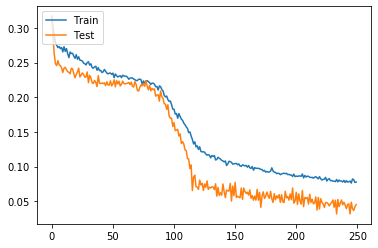

In [9]:
val_loss = hist.history['val_loss']
loss = hist.history['loss']

plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Train', 'Test',], loc='upper left')

### Testing

In [13]:
X_play, y_play = X_train, y_train

i = np.random.randint(0, len(X_play))

X = X_play[i:i+1, :, :]
y_hat = y_play[i].reshape(1, -1)

y_pred = model.predict(X)

y_hat, y_pred

(array([[3.84833035e-06]]), array([[0.01465354]], dtype=float32))

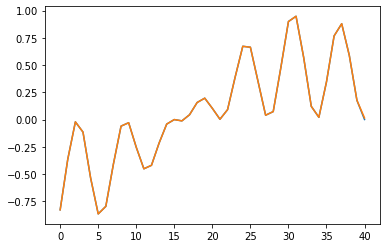

In [14]:
prediction_y = np.concatenate([X[0, :, 1:], y_pred]).reshape(-1)
truth = np.concatenate([X[0, :, 1:], y_hat])
truth_y = truth

plt.plot(truth_y)
plt.plot(prediction_y)

### Multi-Prediction

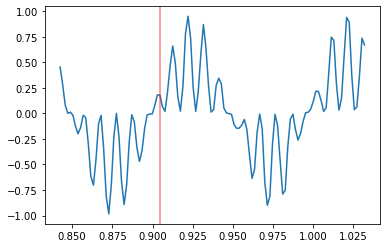

In [15]:
X = X_test[40]
last_true_x = X[-1, 0]
step_size = X[1, 0] - X[0, 0]

for i in range(SERIES_LENGTH*2):
    y_pred = model.predict(X[-SERIES_LENGTH:, :].reshape(1, SERIES_LENGTH, -1))[0]
    next_x = X[-1, 0] + step_size
    xy_pred = np.concatenate([[next_x], y_pred]).reshape(1, -1)
    X = np.concatenate([X, xy_pred])
    
plt.plot(X[:, 0], X[:, 1])
plt.axvline(x=last_true_x, color='r', alpha=0.5)